# AMLD 2021

> ##### Machine Learning in Science: Encoding physical constraints and good development practices


## Example 04 - Physics "embedding" through the neural network

In this notebook, we demonstrating a method for ensuring physical consistency of the predictions by incoorporating knownledge in the neural network

### Workshop Organizers

* Dr. Maria Han Veiga (University of Michigan, USA)

* Dr. Miles Timpe (University of Zurich, Switzerland)

### Import libraries

In [140]:
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.metrics import r2_score


# Global seed value
seed = 42

# Set random seeds
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)


# Versions can also influence reproducibility
from sys import version
print(f"Python version: {version}")

Python version: 3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]


### Load test data and scalers

We focus first on lr_mass.

In [141]:
target = 'lr_mass'

features = ['mtotal', 'gamma', 'b_inf', 'v_inf',
            'targ_core_fraction', 'targ_omega', 'targ_theta', 'targ_phi',
            'proj_core_fraction', 'proj_omega', 'proj_theta', 'proj_phi',
            target]

x_train = pd.read_csv('../datasets/train.csv', usecols=features)
x_test  = pd.read_csv('../datasets/test.csv', usecols=features)

y_train = x_train.pop(target)
y_test  = x_test.pop(target)

# Load scalers and scale targets
scalers = {}
data = {}

y_scaler = load(f"../models/y_scaler_{target}.joblib")

scaled_y_train = y_scaler.transform(y_train.values.reshape(-1, 1))
scaled_y_test  = y_scaler.transform(y_test.values.reshape(-1, 1))
    
# Scale features
x_scaler = load(f"../models/x_scaler.joblib")

scaled_x_train = pd.DataFrame(x_scaler.transform(x_train), columns=x_train.columns)
scaled_x_test = pd.DataFrame(x_scaler.transform(x_test), columns=x_test.columns)

### Setup physics informed neural network

Here, we will first focus on the 'lr_mass' target

In [142]:
# Define model (MLP) using Keras
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Subtract, Lambda, add, ReLU
from keras.callbacks import EarlyStopping

target = 'lr_mass'

_, input_size = scaled_x_train.shape

# load previously trained model
model_uninformed = keras.models.load_model(f"../models/regressor_mlp_{target}.keras")
y_pred_naive = model_uninformed.predict(scaled_x_test)
# Apply inverse scaling to the model predictions
y_scaler = load(f"../models/y_scaler_{target}.joblib")

y_pred_naive = pd.Series(y_scaler.inverse_transform(y_pred_naive.flatten()), name='y_pred').values


/Users/seriousmaria/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


## How do we encode the constraint?

We want to penalise the model if the prediction of 'lr_mass' is larger than 'mtot'.   

This means, if the quantity (lr_mass - mtot) is positive, then we are generating mass.   

We can use a ReLU on this quantity, this way, if this quantity is positive, it will contribute to the loss. If this quantity is 0 or negative, lr_mass is smaller than mtot and it does not contribute to the loss.


$$ ReLU(lr_{mass} - m_{tot}) = \left\{
\begin{array}{ll}
      0 & m_{tot} \geq lr_{mass} \\
      lr_{mass} - m_{tot} & \mbox{ otherwise}
\end{array} \right. $$

In [148]:
# Define model (MLP) using Keras
from keras import backend as K
import tensorflow as tf
import sys

from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()


def custom_loss_wrapper(input_tensor, overshoot_weight=0.5):
    def custom_loss(y_true,y_pred):
        s1 = input_tensor[:,0] 
        overshoot = K.mean(ReLU()(Lambda(lambda x: x)(Subtract()([y_pred,s1]))))
        positivity = K.mean(ReLU()(Lambda(lambda x: -x)(y_pred)))
        return keras.losses.mean_squared_error(y_true, y_pred) + overshoot_weight*overshoot + 0.1*positivity
    return custom_loss

inputs = Input(shape=(input_size,))
f = Dense(24,activation='relu')(inputs)
f = Dense(24,activation='relu')(f)
f = Dense(24,activation='relu')(f)
outputs = Dense(1)(f)

model = keras.Model(inputs, outputs)

model.compile('Adam', loss=custom_loss_wrapper(inputs),metrics=["mse"])

# Fit model
model.fit(x_train, y_train, validation_split = 0.05, epochs=1000, callbacks=[EarlyStopping(patience=70)],verbose=0)

# Make predictions
y_pred = model.predict(x_test)

# Calculate the quality of the predictions with the r2 score
r2 = r2_score(y_test, y_pred)

# Save the model with keras
model.save(f"../models/regressor_mlp_customloss_{target}.keras")

print(f"Prediction r2_score: {r2:.4f}")

/Users/seriousmaria/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Prediction r2_score: 0.9793


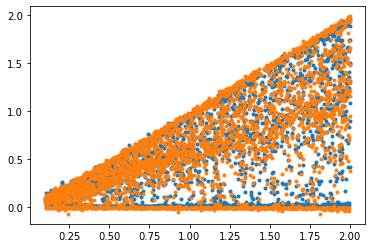

In [149]:
#plt.plot(y_test,y_pred,ls="None",marker='.')
plt.plot(x_test['mtotal'].values,y_pred,ls="None",marker='.')
#plt.plot(y_test,y_pred_naive,ls="None",marker='.')
plt.plot(x_test['mtotal'].values,y_pred_naive,ls="None",marker='.')

Now, we want to predict all masses at the same time, and ensure consistency with the input.

We want to set up a model which will predict the three mass quantities together, and guarantee conservation of mass.

$$ \mathcal{M}(\vec{x}) = \vec{m}, \quad \vec{m} = (lr_{mass}, slr_{mass}, debris_{mass}) $$

under the constraint that

$$ m_{tot} = lr_{mass} + slr_{mass} + debris_{mass} $$

In [150]:
## Load data

In [202]:
targets = ['lr_mass','slr_mass','debris_mass']

features = ['mtotal', 'gamma', 'b_inf', 'v_inf',
            'targ_core_fraction', 'targ_omega', 'targ_theta', 'targ_phi',
            'proj_core_fraction', 'proj_omega', 'proj_theta', 'proj_phi']

x_train = pd.read_csv('../datasets/train.csv', usecols=features)
x_test  = pd.read_csv('../datasets/test.csv', usecols=features)

y_train = pd.read_csv('../datasets/train.csv', usecols=targets)
y_test  = pd.read_csv('../datasets/test.csv', usecols=targets)

In [203]:
## Set up naive model

In [204]:
inputs = Input(shape=(input_size,))
f = Dense(24,activation='relu')(inputs)
f = Dense(24,activation='relu')(f)
f = Dense(24,activation='relu')(f)
outputs = Dense(3)(f)

model = keras.Model(inputs, outputs)

model.compile('Adam', loss="mse",metrics=["mse"])

# Fit model
model.fit(x_train, y_train, validation_split = 0.05, epochs=500, callbacks=[EarlyStopping(patience=70)],verbose=0)

# Make predictions
y_pred_naive = model.predict(x_test)

# Calculate the quality of the predictions with the r2 score
r2 = r2_score(y_test.values, y_pred_naive, multioutput="raw_values")

# Save the model with keras
#model.save(f"../models/regressor_mlp_customloss_{target}.keras")

#print(f"Prediction r2_score: {r2:.4f}")

/Users/seriousmaria/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [212]:
r2 = r2_score(y_test.values, y_pred_naive, multioutput="raw_values")
print(r2)

[0.97196536 0.86684584 0.98120694]


In [183]:
for i in range(3):
    print(r2_score(y_test.values[:,i],y_pred[:,i]))

0.9845679437399064
0.9363460692332634
0.9819478276238545


In [ ]:
## Set up physics aware model

In [187]:
# Define model (MLP) using Keras
from keras import backend as K
import tensorflow as tf
import sys

from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

def custom_loss_wrapper(input_tensor, overshoot_weight=0.5):
    def custom_loss(y_true,y_pred):
        s1 = input_tensor[:,0]
        sum_of_mass = K.sum(y_pred,axis=1)
        overshoot = K.mean(ReLU()(Lambda(lambda x: x)(Subtract()([sum_of_mass,s1]))))
        positivity_lr = K.mean(ReLU()(Lambda(lambda x: -x)(y_pred[:,0])))
        positivity_slr = K.mean(ReLU()(Lambda(lambda x: -x)(y_pred[:,1])))
        positivity_debris = K.mean(ReLU()(Lambda(lambda x: -x)(y_pred[:,2])))
        return keras.losses.mean_squared_error(y_true, y_pred) + overshoot_weight*overshoot\
                + 0.1*(positivity_lr + positivity_slr + positivity_debris)
    return custom_loss

inputs = Input(shape=(input_size,))
f = Dense(24,activation='relu')(inputs)
f = Dense(24,activation='relu')(f)
f = Dense(24,activation='relu')(f)
outputs = Dense(3)(f)

model = keras.Model(inputs, outputs)

model.compile('Adam', loss=custom_loss_wrapper(inputs),metrics=["mse"])

# Fit model
model.fit(x_train, y_train, validation_split = 0.05, epochs=500, callbacks=[EarlyStopping(patience=70)],verbose=0)

# Make predictions
y_pred = model.predict(x_test)

# Calculate the quality of the predictions with the r2 score
r2 = r2_score(y_test, y_pred, multioutput="raw_values")

# Save the model with keras
model.save(f"../models/regressor_mlp_customloss_{target}.keras")

print(f"Prediction r2_score: {r2:.4f}")

/Users/seriousmaria/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [211]:
r2 = r2_score(y_test, y_pred, multioutput="raw_values")
print(r2)

[0.98180912 0.92734481 0.98232397]


In [ ]:
print(np.sum(y_pred_naive,axis=0))

mtot_est_naive = np.sum(y_pred_naive,axis=1)
residual_naive = (x_test.values[:,0] - mtot_est_naive)**2.

mtot_est_phys = np.sum(y_pred,axis=1)
residual_phys = (x_test.values[:,0] - mtot_est_phys)**2.

plt.hist(residual_naive,bins=50)
plt.hist(residual_phys,bins=50)

array([0.30227053, 0.4666669 , 0.19390029, ..., 1.5966623 , 0.16967231,
       0.30766466], dtype=float32)